<a href="https://colab.research.google.com/github/Ardalan-gerami81/HW_ML/blob/main/phase2_99102112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install patchify
import numpy as np
from keras.datasets import mnist
from patchify import patchify
from sklearn.mixture import GaussianMixture
import random
import matplotlib.pyplot as plt

In [13]:
### first part
# we should patchify each image
def patchifyy(images,m):
  patch_list = []
  for image in images:
    h,w = np.shape(image)
    # step of patching is equal to 1
    for i in range(0, h - m + 1,1):
     for j in range(0, w - m + 1,1):
      patch = image[i:i+m, j:j+m]
      patch_list.append(patch.reshape(-1, 1))
  return patch_list
def extract(m,dataset_size):
  # above all we should load the dataset test and then choose 1000 image randomly
  (train_images, _), (_, _) = mnist.load_data()
  train_images_subset = train_images[random.choices(np.arange(60000), k = dataset_size)]
  patches = patchifyy(train_images_subset, m)
  patches_array = np.array(patches).squeeze()
   # save patches in an array
  return patches_array
# Validation
o = extract(8,1000)
print(o.shape)

(441000, 64)


In [14]:
### second part
def parameters_gmm(m,k):
  # above all we should extract our images in dataset test
  patches = extract(m=m,dataset_size = 1000)
  # we should fit a Gaussian Mixture Model then find its parameters
  gmm = GaussianMixture(n_components=k, max_iter =200 , random_state =0 , init_params ='kmeans')
  gmm.fit(patches)
  means = np.ndarray.tolist(gmm.means_.squeeze())
  covariances = np.ndarray.tolist(gmm.covariances_.squeeze())
  mixing_coefficients = np.ndarray.tolist(gmm.weights_.squeeze())
  return means,covariances,mixing_coefficients

In [15]:
#@title Third part
###third part


In [16]:
# now we should wirte a function that denoise a noisy image
def denoise(noisy_image, m, k ,W ,sigma):
  # as we conclude from the project we should update the parameters so above all
  #-> we update them and due to project assumpitation that the mean parameter
  #-> doesn't change
  mean,covariance,mixing_coefficient = parameters_gmm(m,k)
  means = np.array(mean,dtype = np.longdouble)
  covariances = np.array(covariance,dtype = np.longdouble)
  mixing_coefficients = np.array(mixing_coefficient,dtype = np.longdouble)
  # before filling the posterior parameters we should create them by np.zeros
  posterior_means = np.zeros_like(means, dtype = np.longdouble)
  posterior_covariances = np.zeros_like(covariances, dtype = np.longdouble)
  posterior_mixing_coefficients = np.zeros_like(mixing_coefficients, dtype = np.longdouble)
  # we also need covariance matrix of noisy patches as we know from theory part
  #-> of the project  $$$$$$$$$$$$$$$$
  noise_cov = np.eye(m**2) * sigma**2
  # now updating
  for i in range(k):
    # mean doesn't change
    a = covariances[i]
    posterior_mixing_coefficients[i] = mixing_coefficients[i]
    posterior_covariances[i] = np.linalg.inv(np.linalg.inv(a.astype(np.float64))+ W.T@np.linalg.inv(noise_cov.astype(np.float64))@W)
  # now we should update the mean due to patches
  # we will need the denoised patches so first get the patches of a noisy image:
  patchess = patchify(noisy_image, (m,m), step =1).reshape(((noisy_image.shape[0]-m +1)**2, m**2))
  denoised_patches = np.zeros_like(patchess)
  # now updating
  for t in range(denoised_patches.shape[0]):
    probilities_of_posterior = np.zeros(k, dtype = np.longdouble)
    for i in range(k):
      posterior_means[i] = posterior_covariances[i]@(W.T@np.linalg.inv(noise_cov.astype(np.float64))@patchess[t] + np.linalg.inv(covariances[i].astype(np.float64))@means[i])
    for j in range(k):
      probilities_of_posterior[j] = np.log(posterior_mixing_coefficients[j]) - 0.5 * np.log(np.linalg.det(posterior_covariances[j].astype(np.float64)))
      - 0.5*(patchess[t] - posterior_means[j]).T@np.linalg.inv(posterior_covariances[j].astype(np.float64))@(patchess[t] - posterior_means[j])
      if np.isinf(probilities_of_posterior[j]) :
        probilities_of_posterior[j] = -1.0e100
    denoised_patches[t] = posterior_means[np.argmax(probilities_of_posterior)]
  # finaly afer denoising patches we should unpatch images
  coefficients = np.zeros_like(np.zeros((28,28)))
  re_patches = denoised_patches.reshape((int(np.sqrt(denoised_patches.shape[0])), int(np.sqrt(denoised_patches.shape[0])), m, m))
  image_z = np.zeros((28,28))
  for i in range(0, 28 - m + 1,1):
    for j in range(0, 28 - m + 1,1):
      image_z[i:i +m, j:j+ m] += re_patches[i, j]
      coefficients[i:i+m, j:j+m] += np.ones((m , m))
  final_image = np.divide(image_z, coefficients)
  return final_image

for m = 16 and k = 8 :


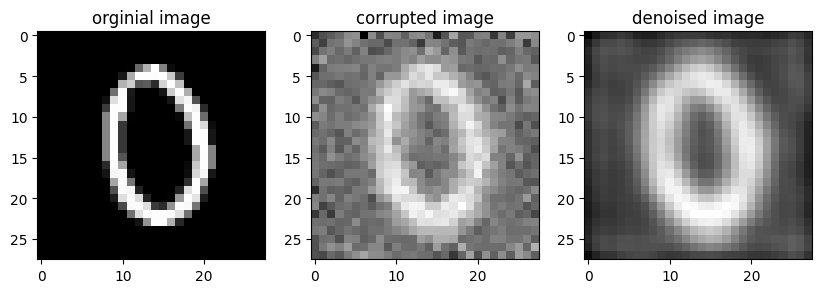

In [27]:
from matplotlib import image as mpimg
fig, axs = plt.subplots(1,3, figsize=(10, 10))
axs = axs.ravel()
for i in range(0,1):
  if i==5:
    j = i+2
  else:
    j = i+1
  print('for m = 16 and k = 8 :')
  image_org = mpimg.imread('30_'+str(int(4*j))+'.png')
  axs[0].set_title('orginial image')
  axs[0].imshow(image_org,cmap = 'gray')
  image_c = mpimg.imread('30_'+str(int(4*j))+'c.png')
  axs[1].set_title('corrupted image')
  axs[1].imshow(image_c,cmap = 'gray')
  W = np.load('W'+str(int(4*j))+'.npy')
  f = denoise(image_c, 4*j, 8,W ,150)
  axs[2].set_title('denoised image')
  axs[2].imshow(f,cmap = 'gray')
  plt.show()
plt.show()